In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("JupyterPySparkTest").getOrCreate()

print("✅ PySpark is working in Jupyter!")
print("PySpark version:", pyspark.__version__)
print("Spark version:", spark.version)

C:\Users\Sandhya\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


✅ PySpark is working in Jupyter!
PySpark version: 4.0.1
Spark version: 4.0.1


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import monotonically_increasing_id
import matplotlib.pyplot as plt

In [3]:
# 1. Setup Spark session and load data
spark = SparkSession.builder.appName("FoodAnalysis").getOrCreate()

df = spark.read.csv("food.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

# Clean column names for safe querying
def clean_column(name):
    return name.strip().replace(" ", "_").replace(".", "_").replace("-", "_")

df = df.toDF(*[clean_column(c) for c in df.columns])

root
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Nutrient Data Bank Number: string (nullable = true)
 |-- Data.Alpha Carotene: string (nullable = true)
 |-- Data.Beta Carotene: string (nullable = true)
 |-- Data.Beta Cryptoxanthin: integer (nullable = true)
 |-- Data.Carbohydrate: double (nullable = true)
 |-- Data.Cholesterol: double (nullable = true)
 |-- Data.Choline: double (nullable = true)
 |-- Data.Fiber: double (nullable = true)
 |-- Data.Lutein and Zeaxanthin: double (nullable = true)
 |-- Data.Lycopene: double (nullable = true)
 |-- Data.Niacin: double (nullable = true)
 |-- Data.Protein: double (nullable = true)
 |-- Data.Retinol: double (nullable = true)
 |-- Data.Riboflavin: double (nullable = true)
 |-- Data.Selenium: double (nullable = true)
 |-- Data.Sugar Total: double (nullable = true)
 |-- Data.Thiamin: double (nullable = true)
 |-- Data.Water: double (nullable = true)
 |-- Data.Fat.Monosaturated Fat: double (nullable = tru

In [5]:
selected_cols = [
    c for c in df.columns
    if any(x in c for x in ["Vitamin", "Protein", "Carbohydrate"])
][:5]

# Include the food name column
columns_to_keep = ["Category"] + ["Description"] + selected_cols

df_selected = df.select(*columns_to_keep)


In [8]:
from pyspark.sql.functions import col, when, lit, min, max

# Step 1: select columns
selected_cols = [c for c in df.columns if any(x in c for x in ["Vitamin", "Protein", "Carbohydrate"])][:5]
category_col = "Category" 
# your food component identifier column

# Step 2: calculate min/max
min_max = df.agg(
    *[min(c).alias(f"{c}_min") for c in selected_cols],
    *[max(c).alias(f"{c}_max") for c in selected_cols]
).collect()[0]

min_values = {c: min_max[f"{c}_min"] for c in selected_cols}
max_values = {c: min_max[f"{c}_max"] for c in selected_cols}

# Step 3: build normalization expressions
normalized_exprs = []
for c in selected_cols:
    expr = when(
        lit(max_values[c]) != lit(min_values[c]),
        (col(c) - lit(min_values[c])) / (lit(max_values[c]) - lit(min_values[c]))
    ).otherwise(lit(0)).alias(c + "_normalized")
    normalized_exprs.append(expr)

# Step 4: create normalized DataFrame keeping category column
df_normalized = df.select(
    category_col,
    *normalized_exprs
)

df_normalized.show(5)


+--------+----------------------------+-----------------------+----------------------------------------+------------------------------------+-----------------------------------+
|Category|Data_Carbohydrate_normalized|Data_Protein_normalized|Data_Vitamins_Vitamin_A___RAE_normalized|Data_Vitamins_Vitamin_B12_normalized|Data_Vitamins_Vitamin_B6_normalized|
+--------+----------------------------+-----------------------+----------------------------------------+------------------------------------+-----------------------------------+
|    Milk|                      0.0689|    0.01318315627799821|                    0.006515005874185624|                5.688282138794085E-5|               7.857142857142856E-4|
|    Milk|                      0.0487|   0.042749264047100985|                    0.006301399124212325|                6.370875995449375E-4|               0.004285714285714286|
|    Milk|                      0.0467|    0.04198131319595546|                    0.003417707999572...|      

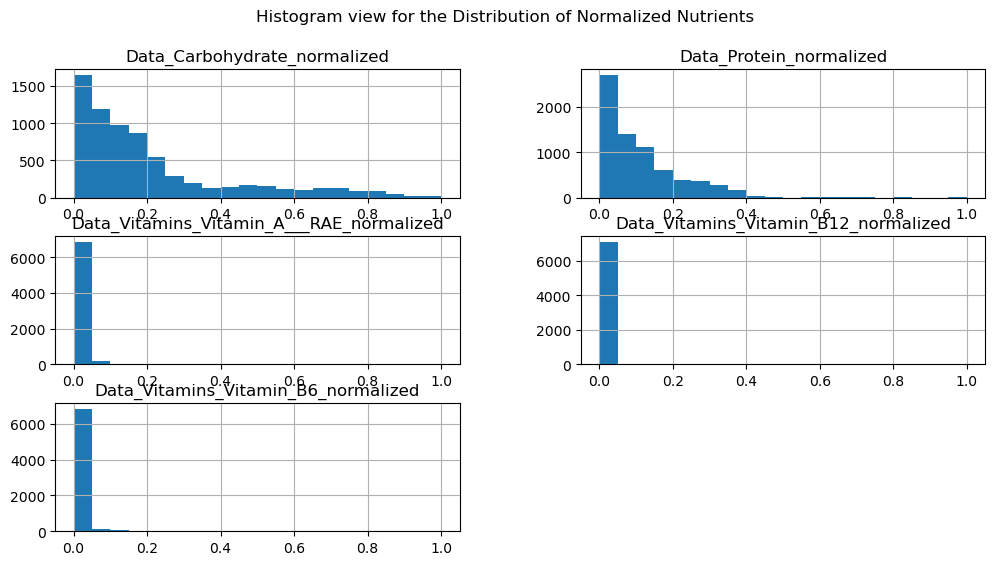

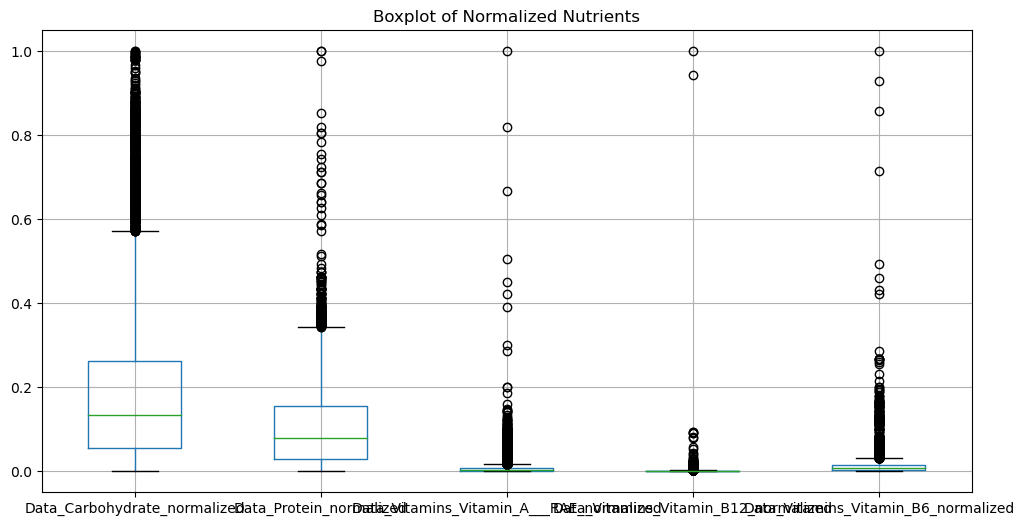

In [10]:
normalized_pd = df_normalized.toPandas()
import matplotlib.pyplot as plt

# Histogram to view the distribution of each nutrient
normalized_pd.hist(column=[c for c in normalized_pd.columns if c != "Category"], bins=20, figsize=(12, 6))

plt.suptitle("Histogram view for the Distribution of Normalized Nutrients")
plt.show()

# Boxplot - visualize spread and outliers per nutrient
normalized_pd.boxplot(column=[c for c in normalized_pd.columns if c != "Category"], figsize=(12,6))
plt.title("Boxplot of Normalized Nutrients")
plt.show()



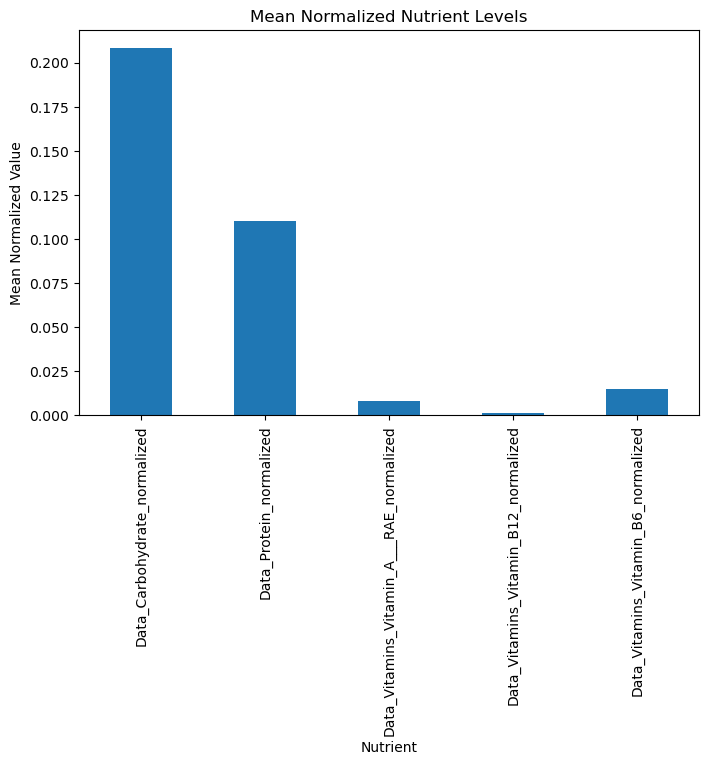

In [12]:
mean_vals = normalized_pd.drop(columns=["Category"]).mean()

mean_vals.plot(kind='bar', figsize=(8,5))
plt.title("Mean Normalized Nutrient Levels")
plt.ylabel("Mean Normalized Value")
plt.xlabel("Nutrient")
plt.show()
